# Read PDF and get the Senetence Structure

In [ ]:
from pypdf import PdfReader
import sys
sys.path.insert(0, 'C://GitHub//FYP_ARSynopsis//utils')
import nltk
nltk.download('punkt')
from nltk import sent_tokenize
from sentence import Sentence
from sentence_transformers import SentenceTransformer
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
reader = PdfReader("../Sample_Reports/1_sample_report.pdf")

In [3]:
print(f"No of pages in the report:\t{reader.get_num_pages()}")
print(f"Content:\n{reader.pages[0].extract_text()[:1000]}...")

No of pages in the report:	92
Content:
Dear Fellow Shareholder,
2018 was a challenging year for community banks as we navigated four interest rate 
increases and heightened competition for deposits and commercial loans. These 
coincided with our core system conversion which positions us to offer our customers 
leading edge cash management and online banking capabilities to compete for deposit 
relationships. We were particularly successful on the lending side of our business as we 
generated solid total loan growth of 6.2% while reducing our non-performing loans by 
$9.0 million, or 49%. 
Net income for 2018 was $5.5 million compared to $3.6 million in 2017. The 
Company’s 2017 results were affected by the revaluation of our deferred tax assets as 
a result of the Tax Cuts and Jobs Act (the “Tax Act”), which resulted in a $1.4 million 
charge to income tax expense in December 2017.
Net interest income for the year ended December 31, 2018 was $26.8 million, an 
increase of $1.8 million 

In [ ]:
text_content = "\n".join([page.extract_text() for page in reader.pages])

In [5]:
sentences = sent_tokenize(text_content)
print(f"Number of sentences:\t{len(sentences)}")

Number of sentences:	1219


In [6]:
# Generate Embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_vectors = embedding_model.encode(sentences)

In [7]:
# Create sentence objects
document = []
for i in range(len(sentences)):
    new_sent = Sentence(index=i,text=sentences[i])
    new_sent.set_embedding(embedding_vectors[i])
    document.append(new_sent)

print(f"Number of sentence objects created:\t{len(document)}")

Number of sentence objects created:	1219


# Clustering

In [8]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np

In [9]:
# Prepare embedding matrix (X) for clustering
embedding_mat = np.array([x._embedding for x in document])
embedding_mat.shape

(1219, 384)

In [10]:
embedding_mat

array([[ 0.03222156, -0.01779375,  0.02715833, ...,  0.00112956,
        -0.06974562, -0.00828854],
       [-0.00575381, -0.02709656, -0.09810603, ..., -0.02276337,
         0.03205092,  0.03505853],
       [ 0.05394006,  0.01201883, -0.02377862, ..., -0.05603693,
        -0.05049745, -0.05448714],
       ...,
       [-0.02048227,  0.04701547, -0.00127403, ...,  0.00725809,
        -0.03310407,  0.04532601],
       [ 0.01500699,  0.00436114,  0.02820873, ..., -0.04528229,
         0.06208638, -0.00862503],
       [-0.03441294,  0.01779911, -0.01665501, ..., -0.12441535,
         0.03376566,  0.01451865]], dtype=float32)

In [11]:
# Cluster with optimal k giving maximum silhouette score
def optimal_k(X,kmin = 6, kmax = 20):
  max_sil = 0
  for k in range(kmin, kmax+1):
    kmeans = KMeans(n_clusters = k, n_init='auto',max_iter=500).fit(X)
    labels = kmeans.labels_
    curr_sil = silhouette_score(X, labels, metric = 'cosine')
    # max_sil variable is initialised to zero. It will store max silhouette score identified till the current value of k
    if max_sil < curr_sil:
      max_sil = curr_sil
      k_optimal = k
      kmeans_optimal = kmeans
  return k_optimal, kmeans_optimal

In [12]:
k_optimal, KMeans_optimal = optimal_k(embedding_mat)
print(f"Sentences have been clustered into {k_optimal} clusters.")

Sentences have been clustered into 17 clusters.


In [13]:
# Validation
score = silhouette_score(embedding_mat, KMeans_optimal.labels_, metric = 'cosine')
print(f"Silhouette Score for the clustering solution: {score}")

Silhouette Score for the clustering solution: 0.09794753044843674


In [14]:
# Add cluster label to sentence
for i in range(len(document)):
    if np.array_equal(document[i]._embedding, embedding_mat[i], equal_nan=False):
        document[i].set_cluster_label(KMeans_optimal.labels_[i])
    else:
        print("Something went wrong, Indexes mismatch")

# Visualize Using T-SNE

In [15]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [16]:
X = np.array([x._embedding for x in document])
tsne = TSNE(n_components = 2,
            perplexity = 10,
            random_state=42,
            n_iter=3000)
tsne_output= tsne.fit_transform(X)
tsne_vec = pd.DataFrame(tsne_output)
tsne_vec.columns = ["tsne1","tsne2"]

In [17]:
labels = [x._cluster for x in document]
tsne_vec["cluster"] = labels
tsne_vec.head()

,tsne1,tsne2,cluster
0,59.378437,4.787724,2
1,49.595509,-63.007420,2
2,-34.605419,-32.507675,12
3,-50.587257,44.054787,12
4,-38.093960,77.328072,14


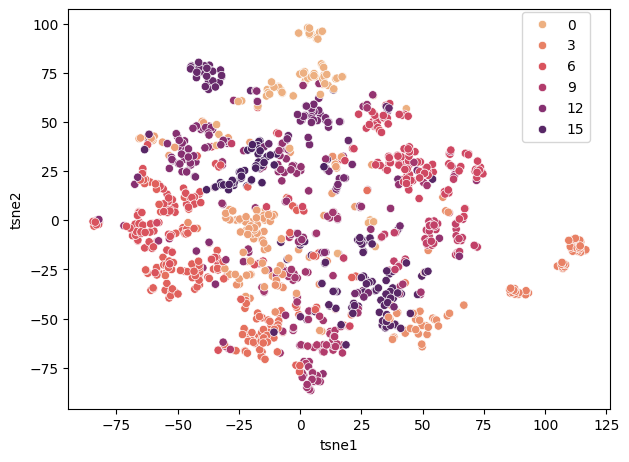

In [18]:
plt.figure()
sns.scatterplot(
    data=tsne_vec,
    x="tsne1",
    y = "tsne2",
    hue = "cluster",
    palette="flare",
)
plt.legend(bbox_to_anchor =(0.9,0.65), loc='lower center')
plt.tight_layout()

plt.show()